In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
df = pd.DataFrame(pd.read_excel('./datasci/cleanedup/whl_2025_base.xlsx'))
df.head()

,game_id,record_id,home_team,away_team,went_ot,home_off_line,home_def_pairing,away_off_line,away_def_pairing,home_goalie,...,home_goals,away_assists,away_shots,away_xg,away_max_xg,away_goals,home_penalties_committed,home_penalty_minutes,away_penalties_committed,away_penalty_minutes
0,game_0001,record_1,thailand,pakistan,0,PP_kill_dwn,PP_kill_dwn,PP_up,PP_up,player_id_142,...,0,2,9,1.4645,0.2166,1,7,14,1,2
1,game_0001,record_2,thailand,pakistan,0,second_off,second_def,second_off,second_def,player_id_142,...,0,2,1,0.0928,0.0928,1,0,0,0,0
2,game_0001,record_19,thailand,pakistan,0,second_off,first_def,first_off,second_def,player_id_142,...,0,0,0,0.0000,0.0000,0,0,0,0,0
3,game_0001,record_11,thailand,pakistan,0,second_off,first_def,second_off,second_def,player_id_142,...,0,0,1,0.0763,0.0763,0,0,0,0,0
4,game_0001,record_10,thailand,pakistan,0,second_off,second_def,first_off,first_def,player_id_142,...,0,0,0,0.0000,0.0000,0,0,0,0,0


In [36]:
'''
IDENTIFIERS:
- game_id
- record_id

ENTITIES:
- home_team
- away_team
- home_goalie
- away_goalie

CONTEXT:
- home_off_line
- away_off_line
- home_def_pairing
- away_def_pairing
- went_ot

OUTCOMES:
- home_goals
- away_goals
- home_shots
- away_shots
- home_penalties_committed
- away_penalties_committed

DERIVED METRICS:
- home_xg
- away_xg
- home_max_xg
- away_max_xg
'''

'\nIDENTIFIERS:\n- game_id\n- record_id\n\nENTITIES:\n- home_team\n- away_team\n- home_goalie\n- away_goalie\n\nCONTEXT:\n- home_off_line\n- away_off_line\n- home_def_pairing\n- away_def_pairing\n- went_ot\n\nOUTCOMES:\n- home_goals\n- away_goals\n- home_shots\n- away_shots\n- home_penalties_committed\n- away_penalties_committed\n\nDERIVED METRICS:\n- home_xg\n- away_xg\n- home_max_xg\n- away_max_xg\n'

In [40]:
sum_cols = [
    "home_goals", "away_goals",
    "home_shots", "away_shots",
    "home_xg", "away_xg",
    "home_assists", "away_assists",
    "home_penalties_committed", "away_penalties_committed",
    "home_penalty_minutes", "away_penalty_minutes",
    "toi",
]
first_cols = [
    "home_team",
    "away_team",
    "went_ot"
]
agg_dict = {}

for col in sum_cols:
    agg_dict[col] = "sum"

for col in first_cols:
    agg_dict[col] = "first"
games = (
    df
    .groupby("game_id", as_index=False)
    .agg(agg_dict)
)
games.shape

(1312, 17)

In [41]:
games["home_score"] = games["home_goals"]
games["away_score"] = games["away_goals"]

games["goal_diff"] = games["home_score"] - games["away_score"]
games["total_goals"] = games["home_score"] + games["away_score"]

games["shot_diff"] = games["home_shots"] - games["away_shots"]
games["total_shots"] = games["home_shots"] + games["away_shots"]
games["total_toi"] = games["toi"]
games["assists"] = games['home_assists'] + games['away_assists']


In [42]:
home_games = games.copy()

home_games["team"] = home_games["home_team"]
home_games["opponent"] = home_games["away_team"]

home_games["goals_for"] = home_games["home_score"]
home_games["goals_against"] = home_games["away_score"]

home_games["shots_for"] = home_games["home_shots"]
home_games["shots_against"] = home_games["away_shots"]

home_games["xg_for"] = home_games["home_xg"]
home_games["xg_against"] = home_games["away_xg"]

home_games["is_home"] = 1
home_games["assists"] = games["home_assists"]


In [43]:
away_games = games.copy()

away_games["team"] = away_games["away_team"]
away_games["opponent"] = away_games["home_team"]

away_games["goals_for"] = away_games["away_score"]
away_games["goals_against"] = away_games["home_score"]

away_games["shots_for"] = away_games["away_shots"]
away_games["shots_against"] = away_games["home_shots"]

away_games["xg_for"] = away_games["away_xg"]
away_games["xg_against"] = away_games["home_xg"]
away_games["is_home"] = 0
away_games["assists"] = games["away_assists"]

In [44]:
# --- LOGIC FOR TOI (The Normalization Key) ---
# 1. Rate Normalization: NEVER use raw xG or Goals for rankings.
#    Always calculate (Stat / toi) * 3600 to get the 'Per 60' rate.
#
# 2. Fatigue Analysis: Track total TOI for 'first_def' and 'first_off'.
#    Teams with extreme workloads for top units should get a 'Sustainability Penalty'
#    in long-term power rankings.
#
# 3. Small Sample Filter: Ignore or down-weight lines with less than
#    a certain threshold of total TOI (e.g., 500 seconds) to avoid 'fluke' stats.
#
# 4. Efficiency Mapping: Combine TOI with xG to see which lines are the
#    most 'lethal' per minute played.
# --- LOGIC FOR SHOTS & ASSISTS (Style & Luck Filter) ---
# 1. Shooting Percentage: (home_goals / home_shots).
#    - Identify 'Sustainability': If a team's shooting % is way above the league average,
#      expect their Power Ranking to drop later (regression).
#
# 2. Playmaking Grade: (home_assists / home_goals).
#    - High ratios indicate 'System Teams' with high puck movement.
#    - Low ratios indicate 'Individualist Teams' (reliant on solo efforts/turnovers).
#
# 3. Chaos Generator: Identify teams with high 'Shots per 60' but low xG.
#    - These teams play a 'dirty' game—relying on rebounds and volume rather than skill.
#
# 4. Assist Map: Link assists to off_line.
#    - Does the 1st line rely on assists while the 2nd line scores solo?
#    - ACTION: Use this to determine which line is easier to 'scout' and shut down.
# --- LOGIC FOR PENALTIES (The Discipline & Chaos Metric) ---
# 1. Discipline Rating: Calculate 'Penalty Minutes per 60'.
#    - Identify teams that 'beat themselves'. A high-penalizing team
#      should have their Power Score docked for 'Unreliability'.
#
# 2. Special Teams Exposure: Compare 'home_penalties' vs 'away_penalties'.
#    - If away_penalties >> home_penalties, the team is mentally fragile on the road.
#
# 3. Penalty-Adjusted xG: Create a 'Clean-Play xG' by filtering out records
#    where home_penalty == 1. This shows how good a team is when playing fair.
#
# 4. The 'Instigator' Factor: Does a team draw more penalties than they take?
#    - Compare 'home_penalties' vs 'away_penalties' in the same game.
#    - Teams that 'draw' penalties have high 'Functional Aggression'.

In [45]:
team_games = pd.concat([home_games, away_games], ignore_index=True)
team_games["goal_diff"] = team_games["goals_for"] - team_games["goals_against"]

team_games["win"] = (team_games["goal_diff"] > 0).astype(int)
team_games["loss"] = (team_games["goal_diff"] < 0).astype(int)
team_season = (
    team_games
    .groupby("team", as_index=False)
    .agg(
        games_played = ("team", "count"),
        wins = ("win", "sum"),
        losses = ("loss", "sum"),
        goals_for = ("goals_for", "sum"),
        goals_against = ("goals_against", "sum"),
        shots_for = ("shots_for", "sum"),
        shots_against = ("shots_against", "sum"),
        xg_for = ("xg_for", "sum"),
        xg_against = ("xg_against", "sum"),
        avg_goal_diff = ("goal_diff", "mean"),
        home_games = ("is_home", "sum"),
        toi = ("toi", "sum"),
        assists=("assists", "sum"),
    ))
team_season["goals_per_game"] = team_season["goals_for"] / team_season["games_played"]
team_season["goals_against_per_game"] = team_season["goals_against"] / team_season["games_played"]

team_season["shot_diff"] = team_season["shots_for"] - team_season["shots_against"]
team_season["xg_diff"] = team_season["xg_for"] - team_season["xg_against"]
team_season["win_pct"] = team_season["wins"] / team_season["games_played"]
team_season["loss_pct"] = team_season["losses"] / team_season["games_played"]


In [46]:
# Home offensive line TOI
home_line_toi = (
    df
    .groupby(["home_team", "home_off_line"], as_index=False)
    .agg(
        total_toi=("toi", "sum"),
        games=("game_id", "nunique")
    )
    .rename(columns={
        "home_team": "team",
        "home_off_line": "off_line"
    })
)

home_line_toi["side"] = "home"


# Away offensive line TOI
away_line_toi = (
    df
    .groupby(["away_team", "away_off_line"], as_index=False)
    .agg(
        total_toi=("toi", "sum"),
        games=("game_id", "nunique")
    )
    .rename(columns={
        "away_team": "team",
        "away_off_line": "off_line"
    })
)

away_line_toi["side"] = "away"

line_toi = pd.concat(
    [home_line_toi, away_line_toi],
    ignore_index=True
)
line_toi_total = (
    line_toi
    .groupby(["team", "off_line"], as_index=False)
    .agg(
        total_toi=("total_toi", "sum"),
        games=("games", "sum")
    )
)
print(line_toi_total.head(128))


            team        off_line  total_toi  games
0         brazil     PP_kill_dwn   45337.28     82
1         brazil           PP_up   41928.47     81
2         brazil  empty_net_line     770.67     12
3         brazil       first_off  108743.00     82
4         brazil      second_off  107499.01     82
..           ...             ...        ...    ...
123    singapore       first_off  110835.72     82
124    singapore      second_off  110264.68     82
125  south_korea     PP_kill_dwn   50307.20     82
126  south_korea           PP_up   40802.87     82
127  south_korea  empty_net_line    2983.97     25

[128 rows x 4 columns]


In [47]:
home_lines = (
    df
    .groupby(["home_team", "home_off_line"], as_index=False)
    .agg(
        toi=("toi", "sum"),
        xg=("home_xg", "sum"),
        goals=("home_goals", "sum"),
        games=("game_id", "nunique")
    )
    .rename(columns={
        "home_team": "team",
        "home_off_line": "off_line"
    })
)

away_lines = (
    df
    .groupby(["away_team", "away_off_line"], as_index=False)
    .agg(
        toi=("toi", "sum"),
        xg=("away_xg", "sum"),
        goals=("away_goals", "sum"),
        games=("game_id", "nunique")
    )
    .rename(columns={
        "away_team": "team",
        "away_off_line": "off_line"
    })
)

off_lines = pd.concat([home_lines, away_lines], ignore_index=True)

off_lines = off_lines[off_lines["toi"] >= 500].copy()

off_lines["xg_60"] = off_lines["xg"] / off_lines["toi"] * 3600
off_lines["goals_60"] = off_lines["goals"] / off_lines["toi"] * 3600# Get team wins from team_season
team_wins = team_season[["team", "wins"]]
off_lines = off_lines.merge(team_wins, on="team", how="left")

off_lines["efficiency"] = off_lines["xg"] / off_lines["toi"]

team_toi = (
    off_lines
    .groupby("team", as_index=False)
    .agg(team_toi=("toi", "sum"))
)

off_lines = off_lines.merge(team_toi, on="team", how="left")

off_lines["fatigue_ratio"] = off_lines["toi"] / off_lines["team_toi"]

off_lines["overworked"] = off_lines["fatigue_ratio"] > 0.185

off_lines = off_lines.sort_values("goals", ascending=False)
print(off_lines.head(32))
print(off_lines["fatigue_ratio"].describe())


            team    off_line       toi       xg  goals  games     xg_60  \
89        panama       PP_up  21646.73  49.4786     66     41  8.228631   
69   netherlands       PP_up  20992.23  54.0857     62     41  9.275266   
127  south_korea  second_off  51622.54  38.6679     61     41  2.696583   
2         brazil   first_off  54467.22  42.7952     61     41  2.828540   
64       morocco       PP_up  24257.46  48.7224     57     41  7.230792   
252         peru       PP_up  20502.44  42.4978     56     41  7.462140   
25       germany       PP_up  20631.48  48.3203     56     41  8.431440   
119    singapore       PP_up  20766.43  51.6766     56     41  8.958485   
87      pakistan  second_off  52828.80  42.3835     54     41  2.888209   
147           uk  second_off  57127.57  39.6546     54     41  2.498908   
245     pakistan  second_off  52104.26  41.1490     54     41  2.843077   
20        france       PP_up  25738.55  59.0966     53     41  8.265724   
154      vietnam       PP

In [48]:
# Check the actual values before the boolean check
print(off_lines[['team', 'off_line', 'toi', 'team_toi', 'fatigue_ratio']].head(10))

# Try a dynamic threshold instead of a hard 0.20
# This identifies the 'top 25%' most used lines in the league
fatigue_threshold = off_lines["fatigue_ratio"].quantile(0.75)
print(f"Top 25% Fatigue Threshold: {fatigue_threshold:.4f}")

off_lines["overworked"] = off_lines["fatigue_ratio"] > fatigue_threshold

            team    off_line       toi   team_toi  fatigue_ratio
89        panama       PP_up  21646.73  304529.73       0.071082
69   netherlands       PP_up  20992.23  310346.06       0.067641
127  south_korea  second_off  51622.54  305210.15       0.169138
2         brazil   first_off  54467.22  303507.76       0.179459
64       morocco       PP_up  24257.46  309973.69       0.078257
252         peru       PP_up  20502.44  313239.44       0.065453
25       germany       PP_up  20631.48  301898.10       0.068339
119    singapore       PP_up  20766.43  309864.37       0.067018
87      pakistan  second_off  52828.80  301873.46       0.175003
147           uk  second_off  57127.57  308052.23       0.185448
Top 25% Fatigue Threshold: 0.1779


In [49]:
# 1. Use the Dynamic Threshold (Top Quartile of the actual data)
# This finds the 'Workhorses' relative to the rest of the league
league_fatigue_cutoff = off_lines["fatigue_ratio"].quantile(0.75)
# 2. Re-calculate the overworked flag
off_lines["overworked"] = off_lines["fatigue_ratio"] > league_fatigue_cutoff

# 3. Validation: Check if we now have 'True' values
overworked_count = off_lines["overworked"].sum()

print(f"League-Wide Fatigue Cutoff: {league_fatigue_cutoff:.4f}")
print(f"Number of 'Overworked' lines identified: {overworked_count}")

# 4. Display the 'Top 10' busiest lines in the league
print("\n--- TOP 10 BUSIEST LINES (RELATIVE FATIGUE) ---")
display(off_lines[['team', 'off_line', 'fatigue_ratio', 'overworked']].head(10))

League-Wide Fatigue Cutoff: 0.1779
Number of 'Overworked' lines identified: 79

--- TOP 10 BUSIEST LINES (RELATIVE FATIGUE) ---


,team,off_line,fatigue_ratio,overworked
89,panama,PP_up,0.071082,False
69,netherlands,PP_up,0.067641,False
127,south_korea,second_off,0.169138,False
2,brazil,first_off,0.179459,True
64,morocco,PP_up,0.078257,False
252,peru,PP_up,0.065453,False
25,germany,PP_up,0.068339,False
119,singapore,PP_up,0.067018,False
87,pakistan,second_off,0.175003,False
147,uk,second_off,0.185448,True


In [50]:
# 1. Filter for only the 'Overworked' lines
fatigue_report = off_lines[off_lines["overworked"] == True].copy()

# 2. Sort by the highest fatigue ratio
fatigue_report = fatigue_report.sort_values("fatigue_ratio", ascending=False)

# 3. Clean up the columns for a 'scouting' look
# We'll show the Team, the specific Line, and how much of the team's time they eat
fatigue_report["Usage %"] = (fatigue_report["fatigue_ratio"] * 100).round(2).astype(str) + "%"
# 1. Create a clean text label based on the overworked flag
off_lines["workload_status"] = off_lines["overworked"].map({
    True: "FATIGUED",
    False: "FRESH",
})

scouting_table = off_lines.copy()
# Get win percentage
team_win_pct = team_season[["team", "win_pct"]]

# Merge into off_lines

off_lines = off_lines.merge(
    team_season[["team", "wins", "win_pct"]],
    on="team",
    how="left"
)


# 2. Display the filtered table
print("--- SCOUTING REPORT: SECOND LINE WORKLOAD ---")
display(second_off_report[['team', 'off_line', 'fatigue_ratio', 'workload_status','win_pct']])

# 4. Display the top 20 most overworked lines
print("--- THE FATIGUE WATCHLIST: TOP 20 WORKHORSE LINES ---")
display(fatigue_report[['team', 'off_line', 'Usage %', 'xg_60', 'games']])




--- SCOUTING REPORT: SECOND LINE WORKLOAD ---


,team,off_line,fatigue_ratio,workload_status,win_pct
2,south_korea,second_off,0.169138,FRESH,0.475610
8,pakistan,second_off,0.175003,FRESH,0.597561
9,uk,second_off,0.185448,FATIGUED,0.475610
10,pakistan,second_off,0.172603,FRESH,0.597561
21,usa,second_off,0.172034,FRESH,0.426829
...,...,...,...,...,...
172,uk,second_off,0.179509,FATIGUED,0.475610
175,saudi_arabia,second_off,0.180881,FATIGUED,0.475610
181,mongolia,second_off,0.178988,FATIGUED,0.329268
184,singapore,second_off,0.176438,FRESH,0.487805


--- THE FATIGUE WATCHLIST: TOP 20 WORKHORSE LINES ---


,team,off_line,Usage %,xg_60,games
259,philippines,first_off,19.44%,1.803998,41
204,indonesia,first_off,19.14%,1.763794,41
146,uk,first_off,18.98%,2.656026,41
224,morocco,first_off,18.91%,2.198434,41
169,china,first_off,18.87%,2.308631,41
...,...,...,...,...,...
274,serbia,first_off,17.84%,2.680839,41
284,south_korea,first_off,17.81%,2.437100,41
295,thailand,second_off,17.81%,2.820183,41
179,france,first_off,17.8%,2.403443,41


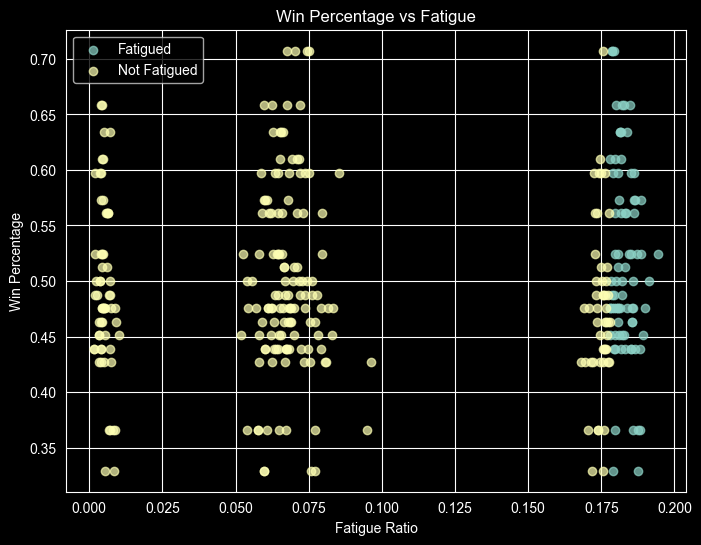

In [51]:
import matplotlib.pyplot as plt

fatigued = off_lines[off_lines["overworked"] == True]
fresh = off_lines[off_lines["overworked"] == False]

plt.figure(figsize=(8,6))

plt.scatter(
    fatigued["fatigue_ratio"],
    fatigued["win_pct"],
    label="Fatigued",
    alpha=0.7
)

plt.scatter(
    fresh["fatigue_ratio"],
    fresh["win_pct"],
    label="Not Fatigued",
    alpha=0.7
)

plt.xlabel("Fatigue Ratio")
plt.ylabel("Win Percentage")
plt.title("Win Percentage vs Fatigue")

plt.legend()
plt.grid(True)

plt.show()

In [54]:
# --- STYLE & LUCK METRICS (TEAM LEVEL) ---
style_luck = team_season.copy()

# 1. Shooting Percentage
style_luck["shoot_pct"] = (
    style_luck["goals_for"] / style_luck["shots_for"]
)

# 2. Playmaking Grade (Assists / Goals)
style_luck["assist_ratio"] = (
    style_luck["assists"] / style_luck["goals_for"]
)

# 3. Shots per 60
style_luck["shots_60"] = (
    style_luck["shots_for"] / style_luck["toi"] * 3600
)

# 4. xG per 60
style_luck["xg_60"] = (
    style_luck["xg_for"] / style_luck["toi"] * 3600
)

# League averages
avg_shoot = style_luck["shoot_pct"].mean()
avg_shots60 = style_luck["shots_60"].mean()
avg_xg60 = style_luck["xg_60"].mean()

# 5. Sustainability Flag (High Shooting %)
style_luck["unsustainable_finish"] = (
    style_luck["shoot_pct"] > avg_shoot * 1.25
)

# 6. Chaos Generator (High shots, Low xG)
style_luck["chaos_team"] = (
    (style_luck["shots_60"] > avg_shots60) &
    (style_luck["xg_60"] < avg_xg60)
)

# Final scouting table
style_luck_table = style_luck[[
    "team",
    "shoot_pct",
    "assist_ratio",
    "unsustainable_finish",
    "chaos_team",
    "win_pct"
]].sort_values("shoot_pct", ascending=False)

style_luck_table.head(20)


KeyError: 'assists'